In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

In [3]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.init_state = init_state

        #Wiener Process by default
        self.bxt = lambda x: 0
        self.sigmaxt = lambda x: 1

    def sampler_init_state(self):
        return np.zeros(self.Nx)

    def EulerSolution(self):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if self.init_state is None:
            x_data[0] = self.sampler_init_state()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            dwt = np.random.normal(0, 1, size = self.Nx) * np.sqrt(dt)
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1]) * dt + self.sigmaxt(x_data[i - 1]) * dwt
        return t_data, x_data

Task 1. Use the stochastic integral Ito, $N=1000$ to simulate and plot a path with $X_0 = 10$ of

the Ornstein-Uhlenbeck process, $\mathbb{\theta} = (-5.0, 0.0, 3.5)$;

the Cox-Ingersoll-Ross process, $\mathbb{\theta} = (2.00, 0.20, 0.15)$;

the Black-Scholes-Merton process, $\mathbb{\theta} = (1.0, 0.2)$.
   

In [4]:
class OrnsteinUhlenbeckProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta, mu, sigma]
        self.bxt = lambda x: self.params[0] * (self.params[1] - x)
        self.sigmaxt = lambda x: self.params[2]

    def sampler_init_state(self):
        return self.params[1] * np.ones(self.Nx)


class CoxIngersollRossProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2, theta3]
        self.bxt = lambda x: self.params[0] - self.params[1] * x
        self.sigmaxt = lambda x: self.params[2] * np.sqrt(np.maximum(x, 0))

    def sampler_init_state(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)


class BlackScholesMertonProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

        # params = [theta1, theta2]
        self.bxt = lambda x: self.params[0] * x
        self.sigmaxt = lambda x: self.params[1] * x

    def sampler_init_state(self):
        return np.ones(self.Nx)

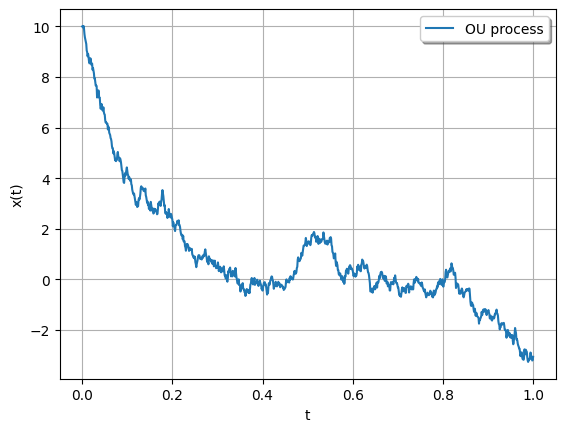

In [5]:
T = 1
Nx = 1
Nt = 1000

init_state = 10 * np.ones(Nx)

theta = 5
mu = 0
sigma = 3.5
params = [theta, mu, sigma]

OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)
t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'OU process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

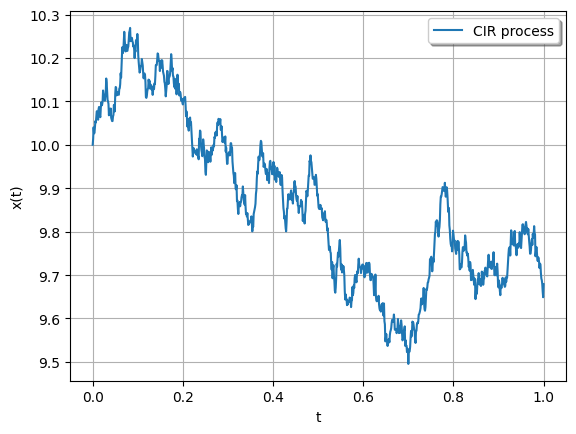

In [6]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'CIR process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

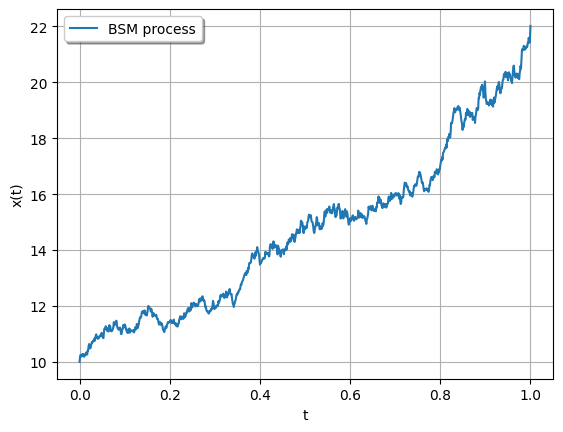

In [7]:
theta1 = 1.0
theta2 = 0.2
params = [theta1, theta2]

BSMProcess = BlackScholesMertonProcess(params, T, Nx, Nt, init_state)
t_data, x_data = BSMProcess.EulerSolution()
plt.plot(t_data, x_data, label = 'BSM process')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 2. Compute a confidence interval of the CIR process from the previous task. Plot the paths and a confidence interval.

In [8]:
def zeta(sigma, theta, t, s):
    return sigma**2 / (4 * theta) * (1 - np.exp(-theta * (t - s)))

def CIRbounds(alpha_interval, params, t, s, xs):
    theta1, theta2, theta3 = params[0], params[1], params[2]
    theta = theta2
    beta = theta1 / theta2
    sigma = theta3

    k = 4  / sigma**2 * theta * beta
    lambd = 4 * theta / sigma**2  * np.exp(-theta * (t - s)) / (1 - np.exp(-theta * (t - s))) * xs
    ksi = norm.ppf(1 - alpha_interval / 2)

    b1 = zeta(sigma, theta, t, s) * (k + lambd - ksi * np.sqrt(2 * (k + 2 * lambd)))
    b2 = zeta(sigma, theta, t, s) * (k + lambd + ksi * np.sqrt(2 * (k + 2 * lambd)))
    return [b1, b2]


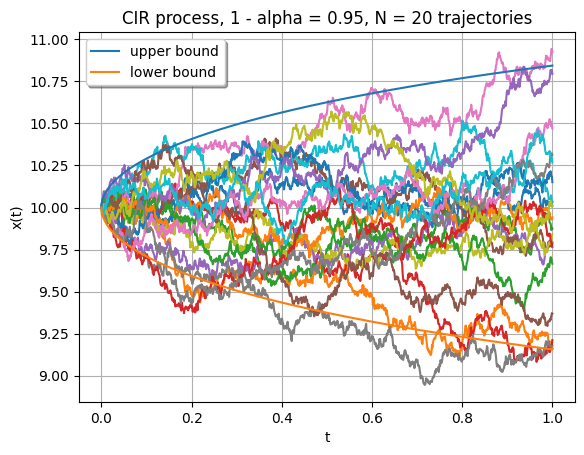

In [9]:
theta1 = 2
theta2 = 0.2
theta3 = 0.15
params = [theta1, theta2, theta3]

Nx = 20

x0 = 10
init_state = x0 * np.ones(Nx)
alpha_interval = 0.05

CIRProcess = CoxIngersollRossProcess(params, T, Nx, Nt, init_state)
t_data, x_data = CIRProcess.EulerSolution()
for k in range(0, Nx):
    plt.plot(t_data, x_data[:,k])

low_bound_data = np.zeros_like(t_data)
up_bound_data = np.zeros_like(t_data)

for i in range(1, len(t_data)):
    bounds = CIRbounds(alpha_interval, params, t_data[i], 0, x0)
    low_bound_data[i] = bounds[0]
    up_bound_data[i] = bounds[1]
low_bound_data[0] = x0
up_bound_data[0] = x0
plt.plot(t_data, up_bound_data, label = f"upper bound")
plt.plot(t_data, low_bound_data, label = f"lower bound")

plt.title(f"CIR process, 1 - alpha = {1-alpha_interval}, N = {Nx} trajectories")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task 3. For the Ornstein-Uhlenbeck process
$$
dX_t = \theta(\mu - X_t)dt + \sigma dW_t, \quad \theta = 1, \quad \mu = 1.2, \quad \sigma = 0.3
$$
generate three paths: $X_0 = 0.0, 2.0, \mathcal{N}\left(\mu, \frac{\sigma^2}{2\theta}\right)$ and plot in graph.


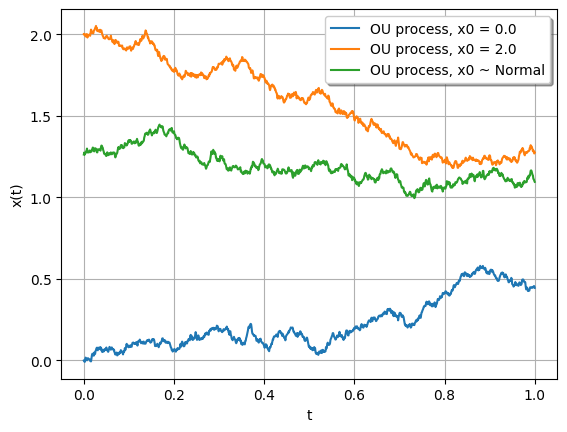

In [10]:
T = 1
Nx = 1
Nt = 1000

theta = 1
mu = 1.2
sigma = 0.3
params = [theta, mu, sigma]

x0 = 0.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')

x0 = 2.0
init_state = x0 * np.ones(Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 = {x0}')


init_state = np.random.normal(mu, sigma**2/(2 * theta), size = Nx)
OUProcess = OrnsteinUhlenbeckProcess(params, T, Nx, Nt, init_state)

t_data, x_data = OUProcess.EulerSolution()
plt.plot(t_data, x_data, label = f'OU process, x0 ~ Normal')

plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid(True)
plt.show()

Task. Define a path with the stationary distribution from the graph and prove mathematically.

In [ ]:
# your code for prove

Task 4.  Design a process that stays in the interval $[0, 1]$ and mean-reverts
around $1/2$, generate a path and plot it in graph. Prove your solution.


Hint
$$
\mu(x) = \theta (1/2 - x), \quad \sigma(x) = \sigma \cdot x (1-x).
$$

That is
$$
dx = \theta (1/2 - x )dt + \sigma \cdot x (1-x) dW.
$$
Note: diffusion goes to zero at boundaries $\sigma(0) = \sigma(1) = 0$ and
mean-reverts  $⇒$ always stay in $[0, 1]$.

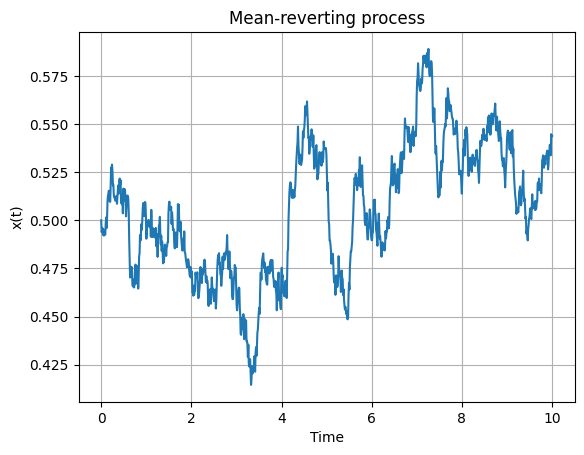

In [6]:


theta = 1.0  
sigma = 0.2
x0 = 0.5     
T = 10.0      
N = 1000
dt = T / N   
t = np.linspace(0, T, N)


def DesingProcess(theta, sigma, x0, T, N):
    dt = T / N
    x = np.zeros(N)
    x[0] = x0
    for i in range(1, N):
        dW = np.sqrt(dt) * np.random.normal()
        drift = theta * (0.5 - x[i-1])
        diffusion = sigma * x[i-1] * (1 - x[i-1])
        x[i] = x[i-1] + drift * dt + diffusion * dW
        
        
        if x[i] < 0:
            x[i] = 0
        elif x[i] > 1:
            x[i] = 1
    return x


path = DesingProcess(theta, sigma, x0, T, N)


plt.plot(t, path)
plt.title('Mean-reverting process')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid(True)
plt.show()

Task 5. Using the class template from Task 1, create classes and plot graphs for the following processes:

1.   Modified CIR model;
2.   Chan-Karolyi-Longstaff-Sanders family of models;
1.   Nonlinear mean reversion Ait-Sahalia model;
2.   Jacobi diffusion process;
1.   Ahn and Gao (inverse of Feller’s square root) model;
2.   Radial Ornstein-Uhlenbeck process.





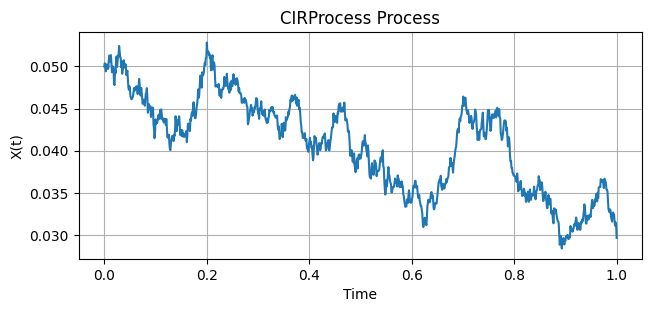

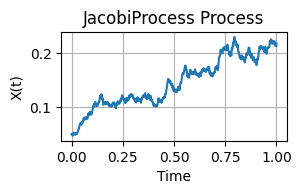

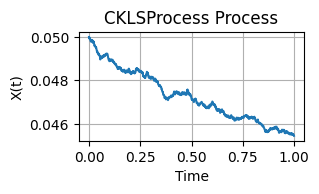

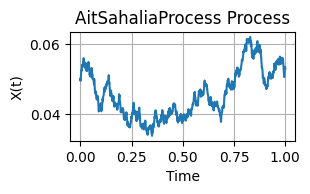

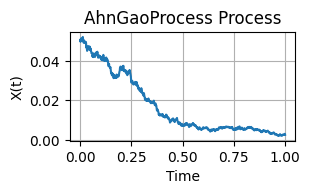

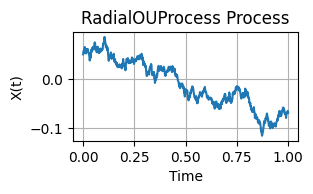

<Figure size 640x480 with 0 Axes>

In [9]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state=None):
        self.params = params
        self.T = T
        self.Nx = Nx
        self.Nt = Nt
        self.dt = T / Nt
        self.state = init_state if init_state is not None else np.zeros(Nx)

    def sample_path(self):
        raise NotImplementedError("This method should be implemented by subclasses.")

    def sampler_init_state(self):
        return self.state

    def plot_path(self, path):
        t = np.linspace(0, self.T, self.Nt)
        plt.plot(t, path)
        plt.title(f'{self.__class__.__name__} Process')
        plt.xlabel('Time')
        plt.ylabel('X(t)')
        plt.grid(True)
        plt.show()



class CIRProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.theta, self.mu, self.sigma = params

    def sample_path(self):
        paths = np.zeros((self.Nt, self.Nx))
        paths[0] = self.sampler_init_state()
        for t in range(1, self.Nt):
            dW = np.random.normal(0, np.sqrt(self.dt), size=self.Nx)
            paths[t] = paths[t-1] + self.theta * (self.mu - paths[t-1]) * self.dt + self.sigma * np.sqrt(paths[t-1]) * dW
           
            paths[t] = np.maximum(paths[t], 0)
        return paths

class CKLSProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.theta, self.mu, self.sigma, self.gamma = params

    def sample_path(self):
        paths = np.zeros((self.Nt, self.Nx))
        paths[0] = self.sampler_init_state()
        for t in range(1, self.Nt):
            dW = np.random.normal(0, np.sqrt(self.dt), size=self.Nx)
            x = paths[t-1]
            drift = self.theta * (self.mu - x)
            diffusion = self.sigma * (x ** self.gamma)
            paths[t] = x + drift * self.dt + diffusion * dW
           
            paths[t] = np.maximum(paths[t], 0)
        return paths
    
    

class AitSahaliaProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.theta, self.mu, self.sigma = params

    def sample_path(self):
        paths = np.zeros((self.Nt, self.Nx))
        paths[0] = self.sampler_init_state()
        for t in range(1, self.Nt):
            dW = np.random.normal(0, np.sqrt(self.dt), size=self.Nx)
            x = paths[t-1]
            drift = self.theta * (self.mu - x) ** 3  
            diffusion = self.sigma * x ** 0.5
            paths[t] = x + drift * self.dt + diffusion * dW
            paths[t] = np.maximum(paths[t], 0)
        return paths



class JacobiProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.theta, self.mu, self.sigma = params

    def sample_path(self):
        paths = np.zeros((self.Nt, self.Nx))
        paths[0] = self.sampler_init_state()
        for t in range(1, self.Nt):
            dW = np.random.normal(0, np.sqrt(self.dt), size=self.Nx)
            x = paths[t-1]
            drift = self.theta * (self.mu - x)
            diffusion = self.sigma * np.sqrt((x * (1 - x)))
            paths[t] = x + drift * self.dt + diffusion * dW
            paths[t] = np.clip(paths[t], 0, 1)  
        return paths



class AhnGaoProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.theta, self.mu, self.sigma = params

    def sample_path(self):
        paths = np.zeros((self.Nt, self.Nx))
        paths[0] = self.sampler_init_state()
        for t in range(1, self.Nt):
            dW = np.random.normal(0, np.sqrt(self.dt), size=self.Nx)
            x = paths[t-1]
            drift = self.theta * (self.mu - np.sqrt(x))
            diffusion = self.sigma * np.sqrt(x)
            paths[t] = x + drift * self.dt + diffusion * dW
            paths[t] = np.maximum(paths[t], 0)
        return paths


class RadialOUProcess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state=None):
        super().__init__(params, T, Nx, Nt, init_state)
        self.theta, self.mu, self.sigma = params

    def sample_path(self):
        paths = np.zeros((self.Nt, self.Nx))
        paths[0] = self.sampler_init_state()
        for t in range(1, self.Nt):
            dW = np.random.normal(0, np.sqrt(self.dt), size=self.Nx)
            x = paths[t-1]
            drift = self.theta * (self.mu - x)
            diffusion = self.sigma
            paths[t] = x + drift * self.dt + diffusion * dW
        return paths



params_cir = (0.5, 0.04, 0.1)
params_jacobi = (0.5, 0.5, 0.2)
params_ckls = (0.5, 0.04, 0.1, 1.5)
params_ait_sahalia = (0.5, 0.04, 0.1)
params_ahn_gao = (0.5, 0.04, 0.1)
params_radial_ou = (0.5, 0.04, 0.1)

T = 1.0
Nx = 1
Nt = 1000
init_state = [0.05]

cir_process = CIRProcess(params_cir, T, Nx, Nt, init_state)
jacobi_process = JacobiProcess(params_jacobi, T, Nx, Nt, init_state)
ckls_process = CKLSProcess(params_ckls, T, Nx, Nt, init_state)
ait_sahalia_process = AitSahaliaProcess(params_ait_sahalia, T, Nx, Nt, init_state)
ahn_gao_process = AhnGaoProcess(params_ahn_gao, T, Nx, Nt, init_state)
radial_ou_process = RadialOUProcess(params_radial_ou, T, Nx, Nt, init_state)


cir_path = cir_process.sample_path()
jacobi_path = jacobi_process.sample_path()
ckls_path = ckls_process.sample_path()
ait_sahalia_path = ait_sahalia_process.sample_path()
ahn_gao_path = ahn_gao_process.sample_path()
radial_ou_path = radial_ou_process.sample_path()


plt.figure(figsize=(16, 10))

plt.subplot(3, 2, 1)
cir_process.plot_path(cir_path)
plt.subplot(3, 2, 2)
jacobi_process.plot_path(jacobi_path)
plt.subplot(3, 2, 3)
ckls_process.plot_path(ckls_path)
plt.subplot(3, 2, 4)
ait_sahalia_process.plot_path(ait_sahalia_path)
plt.subplot(3, 2, 5)
ahn_gao_process.plot_path(ahn_gao_path)
plt.subplot(3, 2, 6)
radial_ou_process.plot_path(radial_ou_path)

plt.tight_layout()
plt.show()





Task 6.

Let $$X(t)=e^{-\kappa t} X_0 + \theta (1-e^{-\kappa t}) + \sigma e^{-\kappa t} \int_0^t e^{\kappa s}\sqrt{X(t)}dW(s)$$ be extract solution for CIR model.


 Expand the functionality of the class CoxIngersollRossProcess(StochasticProcess) and compute the first and second moments of the extract solution $\mathbb{E}\{X^n(t)\}$ using the general formula [Jafari, 2017]
$$
\mathbb{E}\{X^n(t)\} = \sum_{j=0}^{[n/2]}A^{n-2j}(t)B^{2j}(t)
\left(\frac{1}{2\kappa}(e^{2\kappa t} - 1)\right)^{2j}, \quad \forall n \in \mathbb{N},
$$
where $A(t)=e^{-\kappa t X_0} + \theta(1-e^{-\kappa t})$,
$B(t)=\sigma e^{-\kappa t}$, $[n/2]$ denotes the greatest integer less than or equal to $\frac{n}{2}$ and $\kappa=1$, $\theta =0.45$, $\sigma=1$.

Jafari M.A. [The Moments for Solution of the Cox-Ingersoll-Ross Interest Rate Model](https://www.sciepub.com/portal/downloads?doi=10.12691/jfe-5-1-4&filename=jfe-5-1-4.pdf) / M.A. Jafari, S. Abbasian // Journal of Finance
and Economics. – 2017. – Vol. 5, № 1. – P. 34—37

In [16]:
class CoxIngersollRossProcess:
    def __init__(self, X0, kappa, theta, sigma):
        self.X0 = X0  
        self.kappa = kappa  
        self.theta = theta  
        self.sigma = sigma  

    
    def A(self, t):
        kappa = self.kappa
        X0 = self.X0
        theta = self.theta
        return np.exp(-kappa * t) * X0 + theta * (1 - np.exp(-kappa * t))

    
    def B(self, t):
        kappa = self.kappa
        sigma = self.sigma
        return sigma * np.exp(-kappa * t)

    
    def moment(self, n, t):
        kappa = self.kappa
        A_t = self.A(t)
        B_t = self.B(t)
        moment_sum = 0
        
        for j in range(0, (n // 2) + 1):
            term = (A_t**(n - 2*j)) * (B_t**(2*j)) * ((1 / (2 * kappa)) * (np.exp(2 * kappa * t) - 1))**(2*j)
            moment_sum += term
        
        return moment_sum


X0 = 0.05
kappa = 1
theta = 0.45
sigma = 1


cir_process = CoxIngersollRossProcess(X0, kappa, theta, sigma)


t = 1.0
first_moment = cir_process.moment(1, t)
second_moment = cir_process.moment(2, t)

print(f"Первый момент E[X(t)] при t={t}: {first_moment}")
print(f"Второй момент E[X^2(t)] при t={t}: {second_moment}")

Первый момент E[X(t)] при t=1.0: 0.3028482235314231
Второй момент E[X^2(t)] при t=1.0: 1.4728148920379547


Task 7. Suppose we have a standard (zero-mean) Ornstein-Uhlenbeck process defined by
$$
dX_t = -\theta X_t dt + \sigma dW_t, \quad X_0 = x_0,
$$
where $\sigma$ is interpreted as the volatility, and $\theta$ is the speed of reversion.

Define a half-life at time $s$ as the time $h$ such that $𝔼(x_h|x_s)=\frac{1}{2}x_s$. That is, how long until half the deviation from the mean is, in expectation, lost.

This is easy to compute because
\begin{align}
  \frac{1}{2}x_s & =  𝔼(x_h|x_s) \\
                 & = x_s\exp(-\theta h)
\end{align}
and we can cancel the $x_s$ terms to give
\begin{align}
  \frac{1}{2} = \exp(-\theta h)
\end{align}
which rearranges to
\begin{align}
  h = \frac{\ln(2)}{\theta}
\end{align}
The cancellation of $x_s$ means that a half-life does not depend on either $s$ or $x_s$ and so we are entitled to call it "the" half-life of the process.

As one can see, the half-life is a constant for an Ornstein-Uhlenbeck process.



Период полураспада: 1.3862943611198906 единиц времени


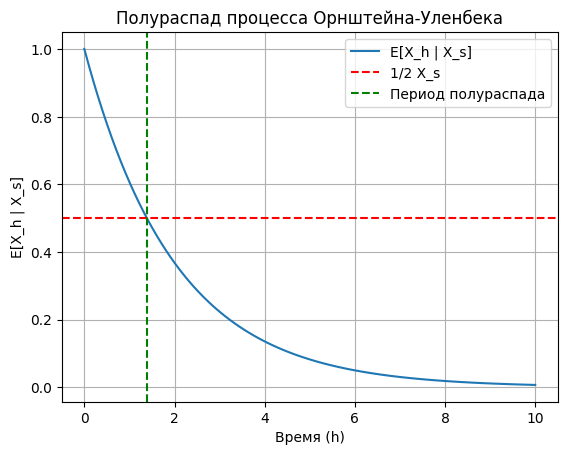

In [23]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, theta, sigma, X0):
        self.theta = theta
        self.sigma = sigma
        self.X0 = X0

    
    def expected_value(self, X_s, h):
        return X_s * np.exp(-self.theta * h)

    
    def half_life(self):
        return np.log(2) / self.theta


theta = 0.5
sigma = 1.0
X0 = 1.0


ou_process = OrnsteinUhlenbeckProcess(theta, sigma, X0)


half_life = ou_process.half_life()
print(f"Период полураспада: {half_life} единиц времени")


time_h = np.linspace(0, 10, 100)
X_s = X0  
expected_values = ou_process.expected_value(X_s, time_h)

plt.plot(time_h, expected_values, label='E[X_h | X_s]')
plt.axhline(X_s / 2, color='r', linestyle='--', label='1/2 X_s')
plt.axvline(half_life, color='g', linestyle='--', label='Период полураспада')
plt.title('Полураспад процесса Орнштейна-Уленбека')
plt.xlabel('Время (h)')
plt.ylabel('E[X_h | X_s]')
plt.legend()
plt.grid(True)
plt.show()